# ELEC0135: AMLS II 2023-2024 Assignment

## Workings Notebook

I found it useful to work in Kaggle (given the 30 hours free per week of GPU time), then separate out the code into modules.

I've kept this notebook in the repo to show a track record of commits and for my own future reference.

### Kaggle Specific Code

In [9]:
# # Useful cleanups to reset status
#!rm -rf /kaggle/working/data
#!rm /kaggle/working/data.zip
#!mv /kaggle/working/artefacts /kaggle/working/artefacts_v1
#!mv /kaggle/working/artefacts_bkp /kaggle/working/artefacts
#!rm -rf /kaggle/working/artefacts

In [1]:
# also required in the `/interactive_runner.ipynb`
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### `/model/util.py`

In [2]:
# -*- coding: utf-8 -*-
"""
Functions for creating and training models, used across the various tasks.
"""
import dataclasses
import datetime as dt
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import timedelta
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from typing import NamedTuple, Tuple


@dataclasses.dataclass
class Params():
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    epsilon: float
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool
    opt: type
        
        
class ResultCollector():
    """
    Utility class to collect up and output results from tasks.
    """
    
    TRAIN_DETAILS_FILE = "train_details.csv"
    TEST_SCORES_FILE = "test_scores.csv"
    
    def __init__(
        self,
        path: Path
    ):
        self.path = path
        self.train_details = pd.DataFrame
        self.test_scores = pd.DataFrame
        
    def get_path(self) -> Path:
        """ Returns the path to which the collectors stores results """
        return self.path

    def add_task_results(self, df_train, df_test) -> None:
        """ Add training details and test scores into the collector"""
        self._add_train_details(df_train)
        self._add_test_scores(df_test)
        
    def get_train_details(self) -> pd.DataFrame:
        """ Returns the training details collected """
        return self.train_details
               
    def get_test_scores(self) -> pd.DataFrame:
        """ Returns the test scores collected """
        return self.test_scores
    
    def restore_results(self, quietly = True) -> None:
        """ Loads results from the location of get_path()"""
        try:
            self.train_details = pd.read_csv(self.path / self.TRAIN_DETAILS_FILE)
            self.test_scores = pd.read_csv(self.path / self.TEST_SCORES_FILE)
        except FileNotFoundError:
            print("Unable to restore history - starting fresh")
            if not quietly:
                raise

    def _add_train_details(self, df: pd.DataFrame) -> None:
        if self.train_details.empty:
            self.train_details = df
        else:
            self.train_details = pd.concat([self.train_details, df])
        
        self._save(self.train_details, self.TRAIN_DETAILS_FILE)
        
    def _add_test_scores(self, df: pd.DataFrame) -> None:
        if self.test_scores.empty:
            self.test_scores = df
        else:
            self.test_scores = pd.concat([self.test_scores, df])
            
        self._save(self.test_scores, self.TEST_SCORES_FILE)
                
    def _save(self, df: pd.DataFrame, name: str) -> None:
        df.to_csv(self.path / name, index=False)
        
        
@dataclasses.dataclass
class ModelWrapper():
    """
    Utility class to hold the "outer" model, and the inner base model
    so that training can be fine-tuned if required.
    """    
    model: keras.Model
    base_model: keras.Model


class LayerNamer():
    """
    Utility class to provide syntatic sugar for naming layers.
    """
    def __init__(self, name: str):
        self.name = name
        self.id = 0
        
    def n(self, prefix: str = ""):
        self.id += 1
        return f"{prefix}-{self.name}-{self.id}"

    
def create_model(base_model_fn: str, name: str, params: Params,
                 fc_layers = 2, fc_neurons = 1024, batch_norm = False,
                 inputs = None) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    n = LayerNamer(name)
    if inputs is None:
        inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    try:
        base_model.name = f"{base_model.name}-{name}"
    except AttributeError:
        base_model._name = f"{base_model.name}-{name}"

    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D(name=n.n("pooling"))(x)
    if batch_norm:
        x = BatchNormalization(name=n.n("bn"))(x)
    x = Flatten(name=n.n("flatten"))(x)
    
    l = 0
    while (l < fc_layers):
        x = Dense(fc_neurons, activation="relu", name=n.n("dense"))(x)
        x = Dropout(0.5, name=n.n("dropout"))(x)
        l = l + 1
    
    outputs = Dense(5, activation="softmax", name=n.n("dense-activation"))(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def create_simple_model(params: Params) -> Model:
    m = keras.Sequential([
        
        tf.keras.Input(shape=(params.image_size, params.image_size, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])
    return ModelWrapper(m, None)


def create_model_ensemble_avg(params: Params, inputs, models: list[ModelWrapper]) -> ModelWrapper:
    """
    Creates an ensemble for the given models, averaging the output.
    """
    outputs = [m.model.outputs[0] for m in models]
    
    em_output = tf.keras.layers.Average()(outputs)
    em_model = tf.keras.Model(inputs=inputs, outputs=em_output)
    
    # just averaging ensembled models - doesn't need fitting.
    em_model.compile(
        optimizer=params.opt(epsilon=params.epsilon),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    
    return ModelWrapper(em_model, None)


def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train: Dataset, ds_valid: Dataset, ds_test: Dataset,
             params: Params, collector: ResultCollector, weights = None) -> None:
    """
    Main task running function.
    """
    print(f"Running Task: {task_id} with params {params}")
    model = model_wrapper.model
    # train
    start = dt.datetime.now()
    df_train = _train(task_id, model, ds_train, ds_valid, params)
    end = dt.datetime.now()
    # scores
    train_result = model.evaluate(ds_train)
    valid_result = model.evaluate(ds_valid)
    test_result = model.evaluate(ds_test)
    print(f"Train Result: {train_result}; Valid Result: {valid_result}; Test Result: {test_result}")
    # shame can't get the early stopping epoch from the monitor itself
    best_epoch = np.argmin(df_train.val_loss) + 1
    total_epochs = len(df_train)
    df_test = _create_test_record(task_id, train_result, valid_result, test_result, best_epoch, total_epochs, (end-start))
    # save
    collector.add_task_results(df_train, df_test)
    _save_confusion_matrix(collector.get_path(), ds_test, model, task_id)
    

def plot_task_comp_by_prefix(collector: ResultCollector, task: str) -> None:
    task_ids = [x for x in collector.get_train_details().task_id.unique() if x.startswith(f"{task}_")]
    plot_task_comp(collector, task_ids)
    

def plot_task_comp(collector: ResultCollector, task_ids: list) -> None:
    _plot_task_comp(collector.get_train_details(), task_ids, collector.get_path())
    

def _plot_task_comp(df_history: pd.DataFrame, task_ids: list, path: Path) -> None:
    df = df_history[(df_history.task_id.isin(task_ids))].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","task_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "task_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="task_id", ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="task_id", ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="task_id", ax=ax3)
    # add to artifacts
    file_name = "learning_curves_" + "_".join(task_ids)
    file_name = file_name.replace(".", "")
    plt.title(file_name)
    plt.savefig(path / file_name)

def _train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    opt = params.opt
    print(f"Using: {opt}")

    model.compile(
        optimizer=params.opt(epsilon=params.epsilon),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.0005, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist["task_id"] = task_id
    df_hist["epoch"] = (df_hist.index+1)
   
    return df_hist


def _create_test_record(task_id: str, train_result: list[float],
                        valid_result: list[float], test_result: list[float],
                        best_epoch: int, total_epochs: int, duration: timedelta):
    return pd.DataFrame({"task_id": [task_id], 
                         "train_accuracy": [train_result[1]],
                         "train_loss" : [train_result[0]],
                         "valid_accuracy": [valid_result[1]],
                         "valid_loss" : [valid_result[0]],
                         "test_accuracy": [test_result[1]],
                         "test_loss" : [test_result[0]],
                         "best_epoch": best_epoch,
                         "total_epochs": total_epochs,
                         "time_secs": [duration.seconds]})


def _save_confusion_matrix(path: Path, ds: Dataset, model: Model, task_id: str) -> None:
    filepath = f"conf_mat_{task_id}.png"
    filepath = path / filepath
    
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    disp.ax_.set_title(task_id)
    
    print(f"Saving confusion matrix to {path}")
    disp.figure_.savefig(filepath, dpi=300)


### `/data/data_processing.py`

In [3]:
# -*- coding: utf-8 -*-
import gdown
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

# handle different structure Kaggle (Notebook) vs. Colab (Modules)
# this wouldn't be kept in any "production" version.
try:
    from AMLS_II_assignment23_24.model.util import Params
except ModuleNotFoundError:
    pass

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from typing import Tuple


def data_preprocessing(path: Path, params: Params, force=False) -> Tuple[Dataset, Dataset, Dataset, dict]:
    """
    Main data preprocessing function - extracts the data to the given path.
    Returns a tuple of Training, Validation, Test datasets, along with class weights.
    """
    file = _download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = _create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = _create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = _create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = _create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = _create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = _create_dataset(test_path, params.image_size, params.batch_size, False)

    # always cache valid & test
    ds_valid = cache_dataset(ds_valid)
    ds_test = cache_dataset(ds_test)
    
    return ds_train, ds_valid, ds_test, _extract_class_weights(df_images)


def _download_data(path: Path, force=False) -> Path:
    """
    Downloads the data from the author's Google Drive account.
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def _create_ds_tree(x, y, path: Path, name: str) -> Path:
    """
    Creates the directory structure for the given dataset.
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def _create_dataset(path: Path, img_size: int, batch_size: int, shuffle = True) -> Dataset:
    """
    Builds up the Dataset object from the given path.
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
        seed=12345,
        shuffle=shuffle,
        crop_to_aspect_ratio=True
    )


def _extract_class_weights(df_data: pd.DataFrame) -> dict:
    """
    Uses the descriptive DataFrame to calculate the class weights
    from the distribution of the labels.
    """
    classes = df_data.label.unique()
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=classes,
                                         y=df_data.label)

    return dict(zip(classes, class_weights))


def convert_dataset_to_float(ds: Dataset) -> Dataset:
    """
    Some models require the input to be coverted to float tensors and
    normalised into a 0-1 range.
    """
    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    return ds.map(convert_to_float)
    

def cache_dataset(ds: Dataset) -> Dataset:
    """
    Dataset caching/pre-fetch utility.
    """
    return (
        ds
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )


def augment_dataset(ds: Dataset, num_repeats: int = 1) -> Dataset:
    """
    Augment the given dataset by flipping left/right, up/down, and
    adjusting the brightness.
    """
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    return (
        ds
        .repeat(num_repeats)
        .map(augment)
    )


def over_sample_class(ds: Dataset, class_label: int, batch_size: int) -> Dataset:
    """
    Over-samples the given class label.  Re-batch to the given size.
    Returns a combined, reshuffled dataset.
    """
    # filter dataset to just the class_label
    ds_filt = ds.unbatch().filter(lambda x, label: tf.equal(tf.argmax(label, axis=0), class_label))
    # combined with original dataset, re-shuffle, and re-batch
    ds_over = tf.data.Dataset.concatenate(ds.unbatch(), ds_filt)
    ds_over = ds_over.shuffle(100000)
    ds_over = ds_over.batch(batch_size)
    return ds_over


### `/main.py`

In [4]:
import dataclasses
import datetime
import os
import pandas as pd
import tensorflow as tf

# handle different structure Kaggle (Notebook) vs. Colab (Modules)
# this wouldn't be kept in any "production" version.
try:
    from AMLS_II_assignment23_24.data_processing.pre_processing import cache_dataset, data_preprocessing
    from AMLS_II_assignment23_24.model.util import Params, ResultCollector, create_model, create_model_ensemble_avg, run_task
except ModuleNotFoundError:
    pass

from docopt import docopt
from pathlib import Path
from tensorflow.keras.optimizers import Adam, AdamW

tf.random.set_seed(67890)

# Starting set of params
params = Params(255, 192, 75, 0.005, True, 7, False, Adam)

ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

collector = ResultCollector(ARTEFACTS_PATH)
collector.restore_results()


def _run_task(selector: str, task: str):
    if (selector is None or selector == "none"):
        return False
    else:
        return (selector == "all") or (task in selector)


# Process Data
print("================")
print("= Loading Data =")
print("================")
cwd = Path(os.getcwd())
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(cwd, params)
print(f"Class Weights: {class_weights}")

= Loading Data =
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Class Weights: {0: 3.9368905243790246, 3: 0.3252317981456148, 1: 1.954956601187757, 2: 1.7935456831517183, 4: 1.6606131160263873}


In [5]:
tasks = "all"
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)


#### Task A: Explore Batch-Size

In [ ]:
if _run_task(tasks, "A"):
    print("\n==== Task A: Explore Batch Size ====")
    for bs in [64, 128, 192, 256]:
        print(f"Batch Size: {bs}")
        params.batch_size = bs
        ds_train, ds_valid, ds_test, class_weights = data_preprocessing(cwd, params)
        model = create_model(tf.keras.applications.EfficientNetB0, "A", params)
        run_task(f"A_{bs}", model, cache_dataset(ds_train), ds_valid, ds_test, params, collector)
    plot_task_comp_by_prefix(collector, "A")


==== Task A: Explore Batch Size ====
Batch Size: 64
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Task: A_64 with params Params(image_size=255, batch_size=64, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
  2/201 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.3008 - loss: 1.6060   

I0000 00:00:1712692522.270220     180 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 ━━━━━━━━━━━━━━━━━━━━ 108s 345ms/step - accuracy: 0.6262 - loss: 1.0475 - val_accuracy: 0.7390 - val_loss: 0.6969
Epoch 2/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7138 - loss: 0.7755 - val_accuracy: 0.7643 - val_loss: 0.6539
Epoch 3/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.7369 - loss: 0.7162 - val_accuracy: 0.7659 - val_loss: 0.6313
Epoch 4/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7501 - loss: 0.6902 - val_accuracy: 0.7715 - val_loss: 0.6160
Epoch 5/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7557 - loss: 0.6623 - val_accuracy: 0.7790 - val_loss: 0.6087
Epoch 6/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.7702 - loss: 0.6444 - val_accuracy: 0.7776 - val_loss: 0.6086
Epoch 7/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7695 - loss: 0.6247 - val_accuracy: 0.7829 - val_loss: 0.5958
Epoch 8/75
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.7827 - loss: 0.6057 - val_accur

^ for some reason the notebook disconnected here, but the analysis continued on the server and the artefacts were all produced.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

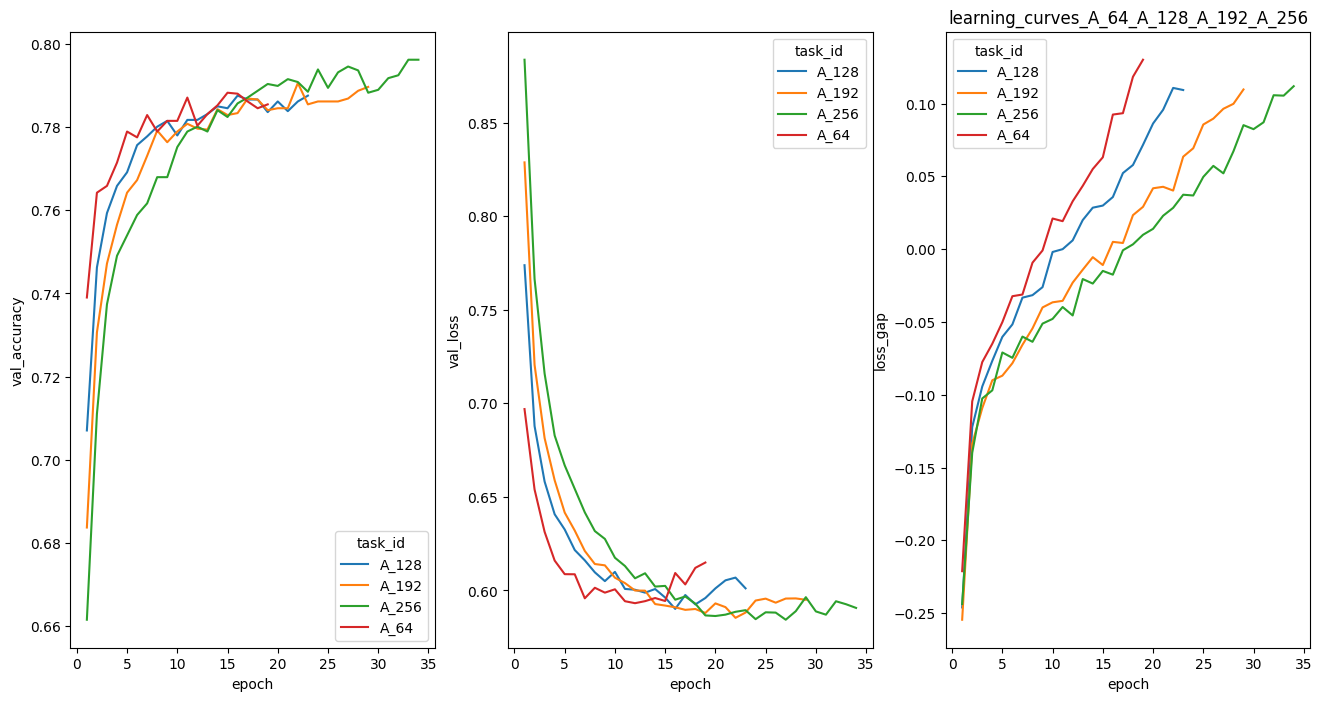

In [6]:
plot_task_comp_by_prefix(collector, "A")

In [7]:
collector.get_test_scores()

,task_id,train_accuracy,train_loss,valid_accuracy,valid_loss,test_accuracy,test_loss,best_epoch,total_epochs,time_secs
0,A_64,0.835476,0.459702,0.780374,0.593190,0.800234,0.578863,12,19,366
1,A_128,0.831814,0.459782,0.787617,0.590120,0.797897,0.584807,16,23,394
2,A_192,0.839682,0.444420,0.790654,0.585369,0.800701,0.585757,22,29,500
3,A_256,0.841396,0.436013,0.794626,0.584355,0.800467,0.578422,27,34,560


In [6]:
# update based on results of Task A, regenerating data cleans up batch-sizes
params.batch_size = 192
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(cwd, params)
ds_train_cached = cache_dataset(ds_train)

print(params)

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Params(image_size=255, batch_size=192, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)


#### Task B: Explore Epsilon


==== Task B: Explore Epsilon ====
Epsilon: 0.0025
Running Task: B_0.0025 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0025, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5950 - loss: 1.1456

W0000 00:00:1712695417.024503     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 581ms/step - accuracy: 0.5957 - loss: 1.1435 - val_accuracy: 0.7098 - val_loss: 0.7566
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.6899 - loss: 0.8274 - val_accuracy: 0.7472 - val_loss: 0.6823
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7126 - loss: 0.7609 - val_accuracy: 0.7582 - val_loss: 0.6543
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7315 - loss: 0.7270 - val_accuracy: 0.7657 - val_loss: 0.6353
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7421 - loss: 0.7029 - val_accuracy: 0.7724 - val_loss: 0.6255
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7469 - loss: 0.6723 - val_accuracy: 0.7729 - val_loss: 0.6175
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7590 - loss: 0.6628 - val_accuracy: 0.7778 - val_loss: 0.6119
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7614 - loss: 0.6471 - val_accuracy: 0.777

W0000 00:00:1712695778.521427     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7762 - loss: 0.6122
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.6875 - loss: 0.8603
Train Result: [0.40536606311798096, 0.8569759130477905]; Valid Result: [0.5905936360359192, 0.7897196412086487]; Test Result: [0.5840827226638794, 0.8037382960319519]
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 392ms/step
Saving confusion matrix to artefacts
Epsilon: 0.005
Running Task: B_0.005 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.005, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5307 - loss: 1.2881

W0000 00:00:1712695866.249187     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 74s 651ms/step - accuracy: 0.5318 - loss: 1.2854 - val_accuracy: 0.6888 - val_loss: 0.8248
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.6675 - loss: 0.8921 - val_accuracy: 0.7308 - val_loss: 0.7253
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7020 - loss: 0.7974 - val_accuracy: 0.7493 - val_loss: 0.6798
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7195 - loss: 0.7559 - val_accuracy: 0.7575 - val_loss: 0.6583
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7315 - loss: 0.7341 - val_accuracy: 0.7617 - val_loss: 0.6461
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7427 - loss: 0.7031 - val_accuracy: 0.7664 - val_loss: 0.6317
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7431 - loss: 0.7010 - val_accuracy: 0.7689 - val_loss: 0.6232
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7544 - loss: 0.6729 - val_accuracy: 0.769

W0000 00:00:1712696258.254608     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7778 - loss: 0.6029
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6909 - loss: 0.8464
Train Result: [0.4397289752960205, 0.8424086570739746]; Valid Result: [0.5810396075248718, 0.7897196412086487]; Test Result: [0.5772344470024109, 0.8044392466545105]
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step
Saving confusion matrix to artefacts
Epsilon: 0.0075
Running Task: B_0.0075 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4981 - loss: 1.3461

W0000 00:00:1712696338.717832     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 71s 613ms/step - accuracy: 0.4994 - loss: 1.3434 - val_accuracy: 0.6624 - val_loss: 0.8868
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.6504 - loss: 0.9414 - val_accuracy: 0.7093 - val_loss: 0.7652
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.6834 - loss: 0.8376 - val_accuracy: 0.7348 - val_loss: 0.7096
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7117 - loss: 0.7880 - val_accuracy: 0.7491 - val_loss: 0.6799
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7254 - loss: 0.7519 - val_accuracy: 0.7556 - val_loss: 0.6628
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7331 - loss: 0.7293 - val_accuracy: 0.7607 - val_loss: 0.6491
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.7386 - loss: 0.7159 - val_accuracy: 0.7643 - val_loss: 0.6370
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.7413 - loss: 0.7017 - val_accuracy: 0.765

W0000 00:00:1712696737.948751     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7791 - loss: 0.6013
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6940 - loss: 0.8431
Train Result: [0.46843966841697693, 0.8311131596565247]; Valid Result: [0.5803427696228027, 0.7901869416236877]; Test Result: [0.582131028175354, 0.8014018535614014]
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step
Saving confusion matrix to artefacts
Epsilon: 0.01
Running Task: B_0.01 with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.01, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.4793 - loss: 1.3632

W0000 00:00:1712696828.181081     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 72s 630ms/step - accuracy: 0.4807 - loss: 1.3606 - val_accuracy: 0.6350 - val_loss: 0.9210
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.6428 - loss: 0.9707 - val_accuracy: 0.7049 - val_loss: 0.7874
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.6755 - loss: 0.8670 - val_accuracy: 0.7297 - val_loss: 0.7269
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.7004 - loss: 0.8081 - val_accuracy: 0.7477 - val_loss: 0.6923
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7141 - loss: 0.7727 - val_accuracy: 0.7514 - val_loss: 0.6740
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7218 - loss: 0.7514 - val_accuracy: 0.7551 - val_loss: 0.6597
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7261 - loss: 0.7340 - val_accuracy: 0.7610 - val_loss: 0.6466
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.7391 - loss: 0.7141 - val_accuracy: 0.764

W0000 00:00:1712697377.497267     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7789 - loss: 0.6016
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.6964 - loss: 0.8446
Train Result: [0.42290034890174866, 0.848718523979187]; Valid Result: [0.5780870914459229, 0.7929906249046326]; Test Result: [0.5848280787467957, 0.8014018535614014]
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step
Saving confusion matrix to artefacts


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

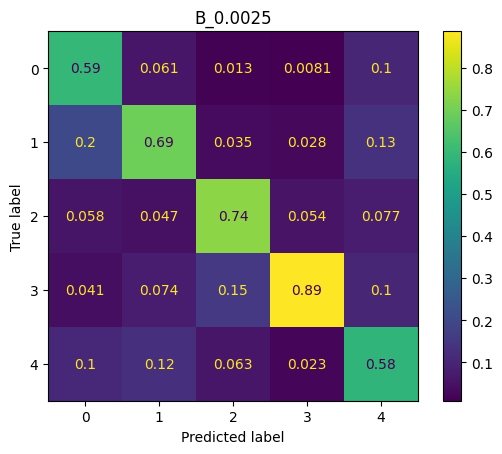

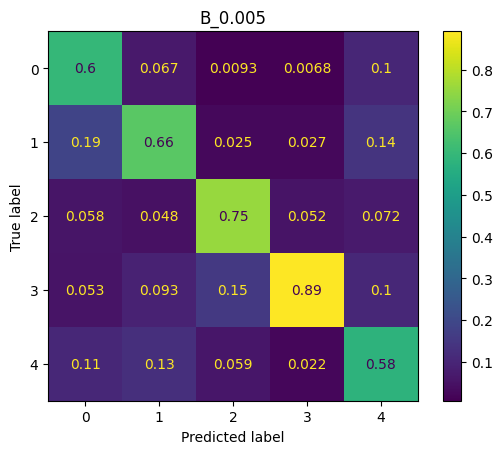

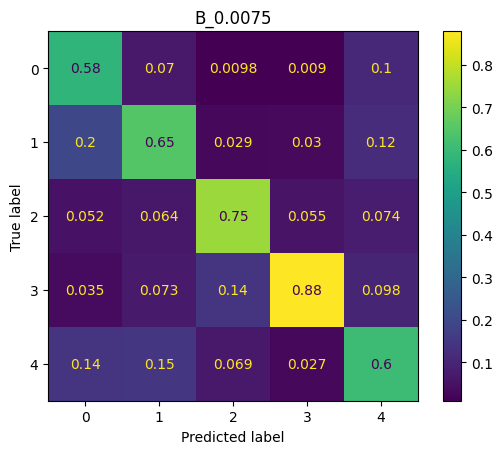

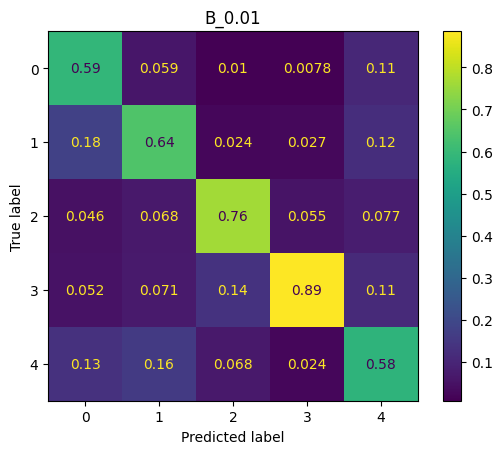

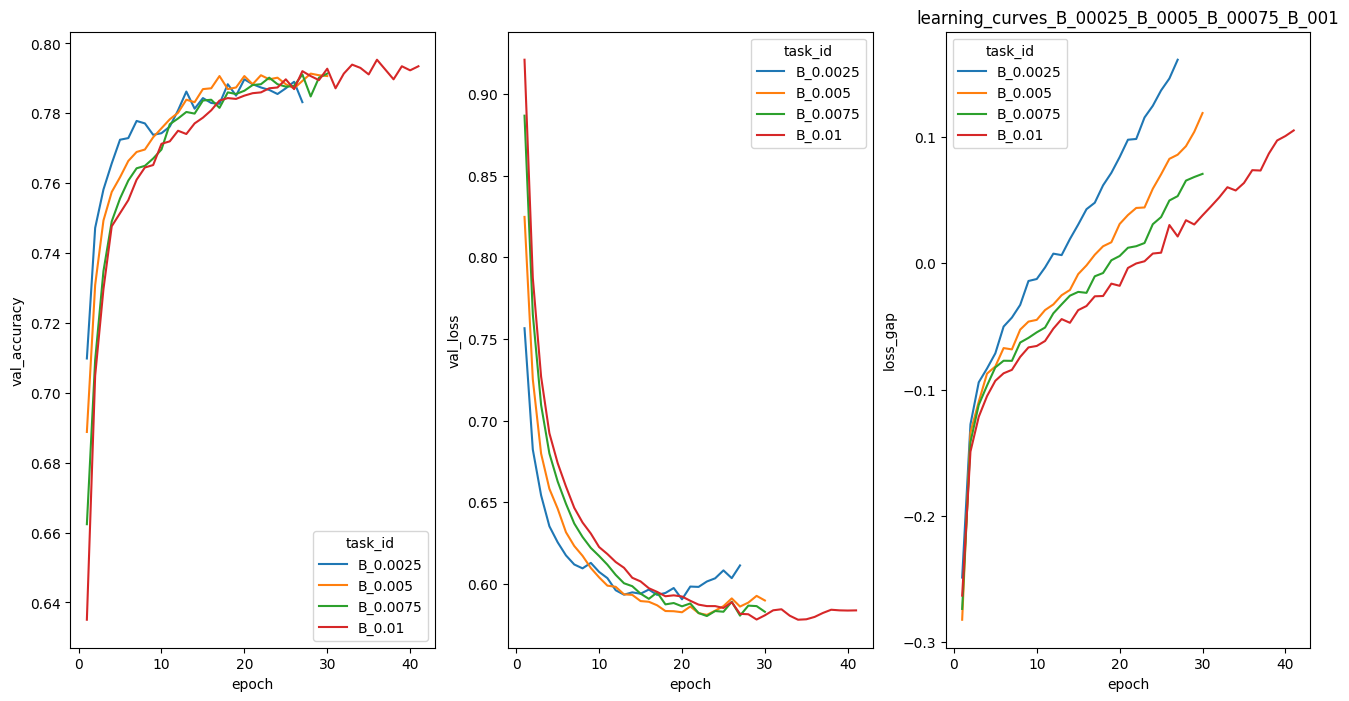

In [10]:
if _run_task(tasks, "B"):
    print("\n==== Task B: Explore Epsilon ====")
    for e in [0.0025, 0.0050, 0.0075, 0.01]:
        print(f"Epsilon: {e}")
        p = dataclasses.replace(params)
        p.epsilon = e
        model = create_model(tf.keras.applications.EfficientNetB0, "B", p)
        run_task(f"B_{e}", model, ds_train_cached, ds_valid, ds_test, p, collector)
    plot_task_comp_by_prefix(collector, "B")

In [11]:
collector.get_test_scores()

,task_id,train_accuracy,train_loss,valid_accuracy,valid_loss,test_accuracy,test_loss,best_epoch,total_epochs,time_secs
0,A_64,0.835476,0.459702,0.780374,0.593190,0.800234,0.578863,12,19,366
1,A_128,0.831814,0.459782,0.787617,0.590120,0.797897,0.584807,16,23,394
2,A_192,0.839682,0.444420,0.790654,0.585369,0.800701,0.585757,22,29,500
3,A_256,0.841396,0.436013,0.794626,0.584355,0.800467,0.578422,27,34,560
0,B_0.0025,0.856976,0.405366,0.789720,0.590594,0.803738,0.584083,20,27,404
0,B_0.005,0.842409,0.439729,0.789720,0.581040,0.804439,0.577234,23,30,441
0,B_0.0075,0.831113,0.468440,0.790187,0.580343,0.801402,0.582131,23,30,447
0,B_0.01,0.848719,0.422900,0.792991,0.578087,0.801402,0.584828,34,41,598


#### Task C: Baseline Model Comparison

In [7]:
# update based on results of Task B
params.epsilon = 0.0075
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)


In [ ]:
if _run_task(tasks, "C"):
    print("\n==== Task C: Baseline Model Comparison ====")
    for m in [tf.keras.applications.ConvNeXtTiny, tf.keras.applications.ConvNeXtBase,
              tf.keras.applications.EfficientNetB0, tf.keras.applications.EfficientNetV2B0]:
        print(f"Model: {m}")
        model = create_model(m, "C", params)
        run_task(f"C_{model.base_model.name}", model, ds_train_cached, ds_valid, ds_test, params, collector)
    plot_task_comp_by_prefix(collector, "C")


==== Task C: Baseline Model Comparison ====
Model: <function ConvNeXtTiny at 0x7d35109ef9a0>
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Running Task: C_convnext_tiny-C with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75


I0000 00:00:1712730161.913213     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712730161.951178     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730161.951486     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730161.951852     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730161.952198     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730161.952532     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730161.952851     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730161.953196     119 graph_launch.cc:671] Fallback to op-by-op mode because m

66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5261 - loss: 1.3290

W0000 00:00:1712730208.175306     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730208.175823     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730208.176487     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5271 - loss: 1.3265

W0000 00:00:1712730217.054834     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.055231     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.055670     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.056050     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.056392     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.056723     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.057039     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712730217.057426     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5281 - loss: 1.3240 - val_accuracy: 0.6678 - val_loss: 0.8777
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 624ms/step - accuracy: 0.6468 - loss: 0.9475 - val_accuracy: 0.7012 - val_loss: 0.7932
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.6775 - loss: 0.8631 - val_accuracy: 0.7152 - val_loss: 0.7578
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 624ms/step - accuracy: 0.6943 - loss: 0.8094 - val_accuracy: 0.7252 - val_loss: 0.7354
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7024 - loss: 0.7937 - val_accuracy: 0.7308 - val_loss: 0.7199
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7106 - loss: 0.7683 - val_accuracy: 0.7388 - val_loss: 0.7068
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7178 - loss: 0.7482 - val_accuracy: 0.7409 - val_loss: 0.6929
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 623ms/step - accuracy: 0.7304 - loss: 0.7286 - val_accuracy: 0.7453 

W0000 00:00:1712731971.545259     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712731971.545660     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712731971.546200     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 34s 510ms/step - accuracy: 0.8642 - loss: 0.3910
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy: 0.7842 - loss: 0.6135
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.6923 - loss: 0.8333
Train Result: [0.38477668166160583, 0.8674923777580261]; Valid Result: [0.6014295816421509, 0.7892523407936096]; Test Result: [0.5834469795227051, 0.7957943677902222]
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:36 4s/step

W0000 00:00:1712732017.325390     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.325775     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.326225     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.326585     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.326959     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.327348     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.327723     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732017.328098     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step


W0000 00:00:1712732031.303242     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732031.303716     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732031.304141     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732031.307379     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732031.307825     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732031.308299     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts
Model: <function ConvNeXtBase at 0x7d35109efac0>
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Running Task: C_convnext_base-C with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5335 - loss: 1.3192

W0000 00:00:1712732226.722814     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732226.723246     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712732226.723802     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5345 - loss: 1.3164 - val_accuracy: 0.6893 - val_loss: 0.8215
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6630 - loss: 0.8955 - val_accuracy: 0.7311 - val_loss: 0.7133
Epoch 3/75
25/67 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6986 - loss: 0.7847

^ again, the notebook disconnected here, but the analysis continued on the server and the artefacts were all produced.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

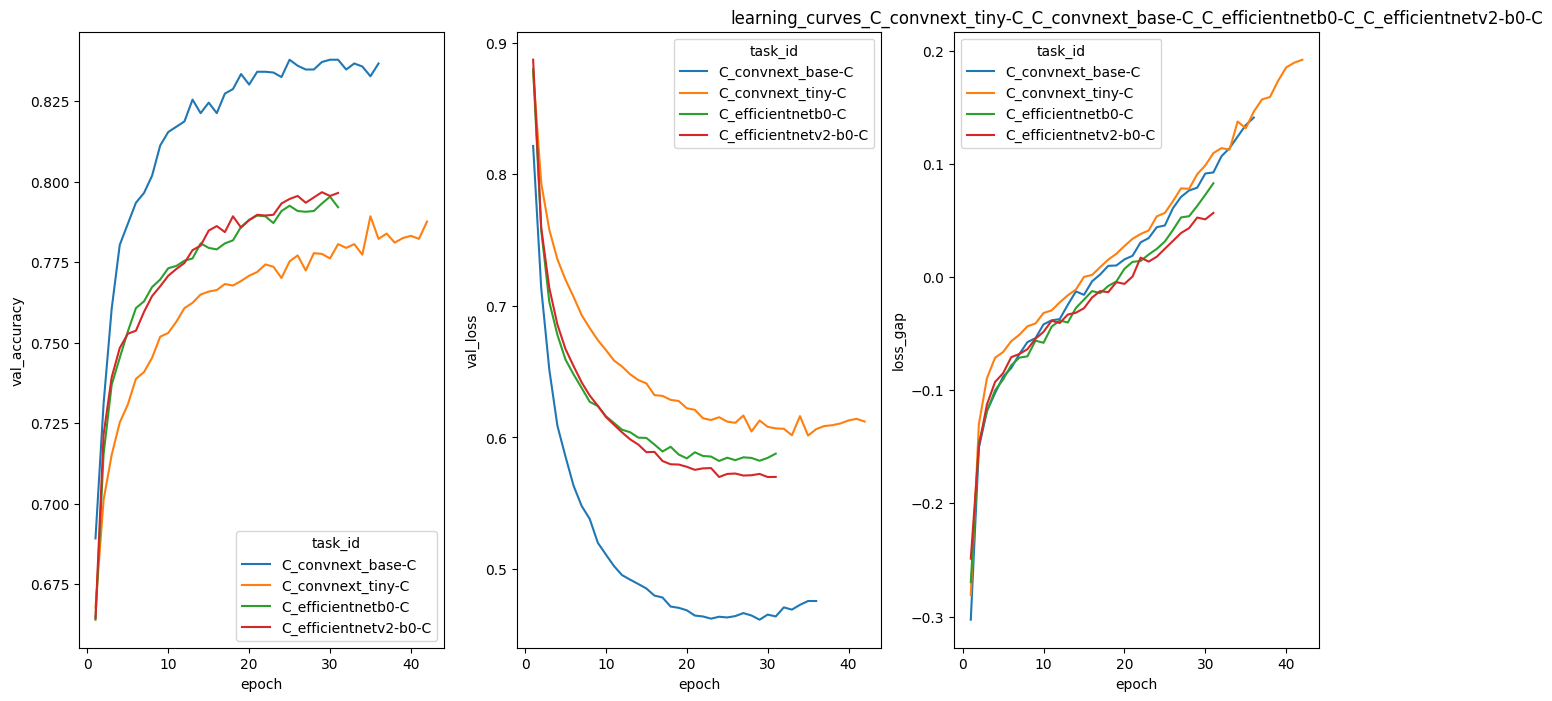

In [6]:
plot_task_comp_by_prefix(collector, "C")

In [19]:
collector.get_test_scores()

,task_id,train_accuracy,train_loss,valid_accuracy,valid_loss,test_accuracy,test_loss,best_epoch,total_epochs,time_secs
0,A_64,0.828932,0.478066,0.781308,0.605977,0.793692,0.592617,12,19,311
0,A_128,0.816390,0.502783,0.780841,0.598905,0.787150,0.595505,13,20,298
0,A_192,0.821298,0.502205,0.783879,0.589435,0.795327,0.601508,17,24,370
0,A_256,0.819350,0.500017,0.778505,0.594274,0.791822,0.594091,20,27,411
0,B_0.0025,0.863286,0.402410,0.785981,0.593371,0.800000,0.596826,20,27,367
0,B_0.005,0.846693,0.443738,0.787617,0.586890,0.795561,0.594456,22,29,380
0,B_0.0075,0.836722,0.461609,0.783645,0.586858,0.795093,0.593379,25,32,406
0,B_0.01,0.830256,0.473586,0.785981,0.585125,0.796028,0.596628,28,35,437
0,C_convnext_tiny-C,0.859235,0.413891,0.779673,0.608301,0.794393,0.595749,17,24,882
0,C_convnext_base-C,0.871310,0.363167,0.818925,0.508734,0.828972,0.529574,16,23,2223


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

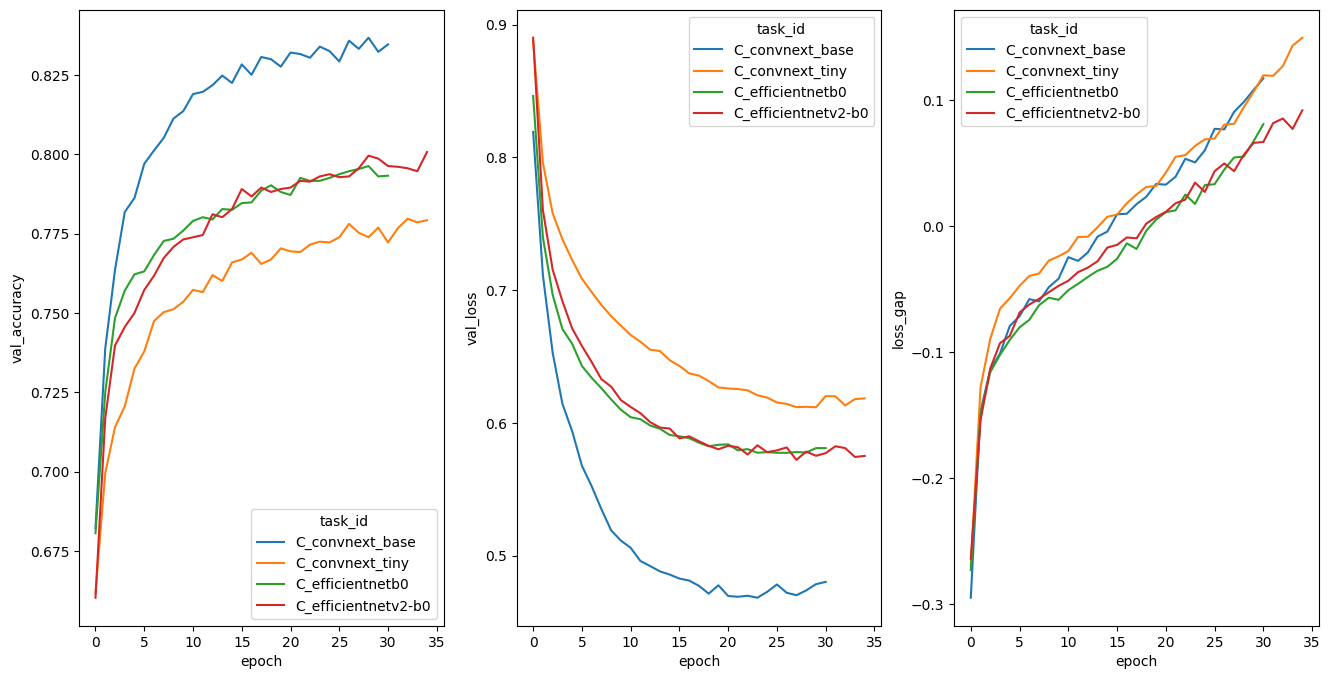

In [42]:
plot_task_comp_by_prefix(collector, "C")

#### Task D: Best-of-Breed Model

In [6]:
# update based on results of Tasks A&B
params.batch_size = 192
params.epsilon = 0.0075

# now used AdamW optimiser
params.opt = AdamW

print(params)

# create some re-usable fine-tuning parameters
ft_params = dataclasses.replace(params)
ft_params.epochs = 1
ft_params.epsilon = 1e-5
ft_params.early_stopping_patience = 1

print(ft_params)
  
# oversample & augment dataset
ds_train_aug_over = augment_dataset(over_sample_class(ds_train, 0, params.batch_size), 2)
ds_train_aug = augment_dataset(ds_train, 2)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Params(image_size=255, batch_size=192, epochs=1, epsilon=1e-05, early_stopping=True, early_stopping_patience=1, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task D: Best-of-Breed Model ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Running Task: D_init with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
      1/Unknown 96s 96s/step - accuracy: 0.1510 - loss: 2.6135

I0000 00:00:1712738789.831030     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    141/Unknown 203s 761ms/step - accuracy: 0.5300 - loss: 1.4340

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 225s 911ms/step - accuracy: 0.5310 - loss: 1.4304 - val_accuracy: 0.7362 - val_loss: 0.8363
Epoch 2/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 132s 679ms/step - accuracy: 0.6736 - loss: 0.8994 - val_accuracy: 0.7519 - val_loss: 0.7447
Epoch 3/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 133s 681ms/step - accuracy: 0.7058 - loss: 0.7968 - val_accuracy: 0.7554 - val_loss: 0.6968
Epoch 4/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 133s 679ms/step - accuracy: 0.7329 - loss: 0.7283 - val_accuracy: 0.7706 - val_loss: 0.6444
Epoch 5/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 133s 685ms/step - accuracy: 0.7471 - loss: 0.6948 - val_accuracy: 0.7741 - val_loss: 0.6332
Epoch 6/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 131s 670ms/step - accuracy: 0.7543 - loss: 0.6758 - val_accuracy: 0.7759 - val_loss: 0.6224
Epoch 7/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 132s 680ms/step - accuracy: 0.7651 - loss: 0.6413 - val_accuracy: 0.7773 - val_loss: 0.6166
Epoch 8/75
142/142 ━━━━━━━━━━━━━━━━━━━━ 130s 669ms/step - accuracy: 0.7728 - loss: 0.62

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7950 - loss: 0.5749
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.7402 - loss: 0.7333
Train Result: [0.32325446605682373, 0.903592586517334]; Valid Result: [0.5762892365455627, 0.7920560836791992]; Test Result: [0.5731519460678101, 0.8093457818031311]
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step
Saving confusion matrix to artefacts
Running Task: D_tuned with params Params(image_size=255, batch_size=192, epochs=1, epsilon=1e-05, early_stopping=True, early_stopping_patience=1, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping


2024-04-10 09:52:15.259809: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-10 09:52:15.379019: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.119319438s
Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-10 09:52:16.780801: E external/

    142/Unknown 317s 1s/step - accuracy: 0.7444 - loss: 0.7571

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


142/142 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.7448 - loss: 0.7561 - val_accuracy: 0.8175 - val_loss: 0.5142
Restoring model weights from the end of the best epoch: 1.
142/142 ━━━━━━━━━━━━━━━━━━━━ 126s 638ms/step - accuracy: 0.8350 - loss: 0.4604
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7812 - loss: 0.5997

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.8116 - loss: 0.5199
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7672 - loss: 0.6411
Train Result: [0.460196852684021, 0.8362963199615479]; Valid Result: [0.5141921043395996, 0.8175233602523804]; Test Result: [0.5001769065856934, 0.8247663378715515]
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step
Saving confusion matrix to artefacts


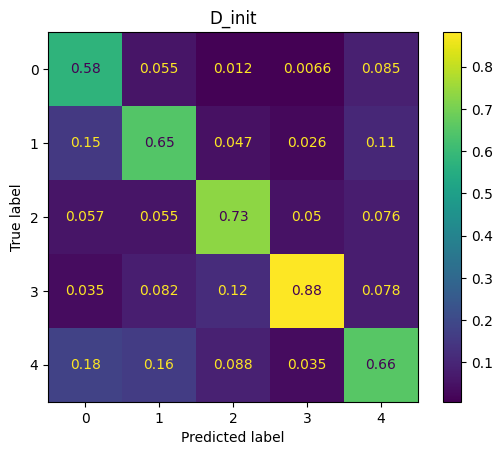

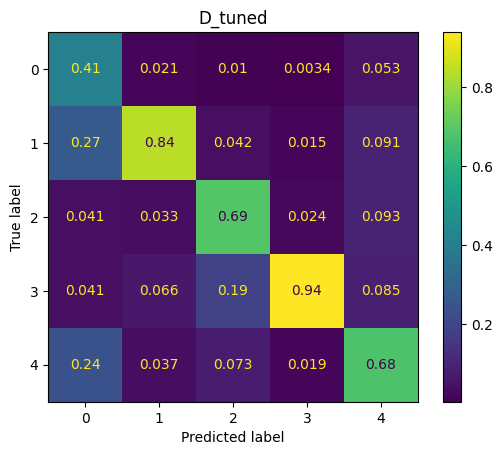

In [7]:
if _run_task(tasks, "D"):
    print("\n==== Task D: Best-of-Breed Model ====")
    # initial training
    model_d = create_model(tf.keras.applications.EfficientNetV2B0, "D", params, batch_norm=True)
    run_task(f"D_init", model_d, ds_train_aug_over, ds_valid, ds_test, params, collector, class_weights)
    # fine-tune by allowing base model to be re-trained
    model_d.base_model.trainable = True
    run_task(f"D_tuned", model_d, ds_train_aug_over, ds_valid, ds_test, ft_params, collector, class_weights)

In [ ]:
print("\n========================")
print("==== Ablation Study ====")
print("========================")

print("\n==== Task E: Remove Fine-Tuning ====")
"""
Task E is basically the same as D_init, i.e., the best of breed model before
the fine-tuning has been run.  Don't re-run again here, to save on compute.
"""
# model = create_model(tf.keras.applications.ConvNeXtBase, params, bn=True)
# run_task(f"E", model, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)
# del model

In [7]:
# update based on results of Tasks A&B
params.batch_size = 192
params.epsilon = 0.0075
params.opt = AdamW
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task F: Remove over-sampling ====
Running Task: F with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 160s 873ms/step - accuracy: 0.5430 - loss: 1.4123 - val_accuracy: 0.7294 - val_loss: 0.8364
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 556ms/step - accuracy: 0.6904 - loss: 0.8675 - val_accuracy: 0.7556 - val_loss: 0.7340
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 563ms/step - accuracy: 0.7191 - loss: 0.7688 - val_accuracy: 0.7671 - val_loss: 0.6631
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 557ms/step - accuracy: 0.7360 - loss: 0.7311 - val_accuracy: 0.7708 - val_loss: 0.6344
Epoch 5/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 571ms/step - accuracy: 0.7518 - loss: 0.6827 - val_accuracy: 0.7752 - val_loss: 0.6204
Epoch 6/75
134/1

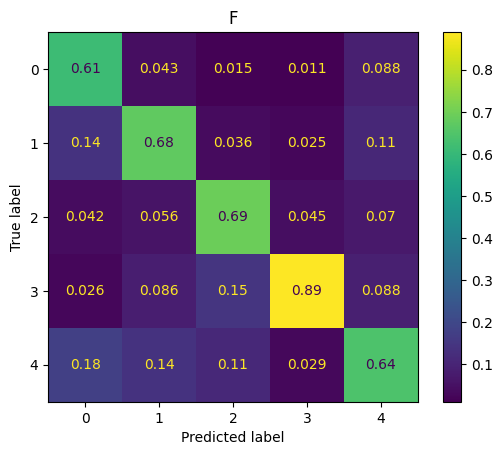

In [9]:
if _run_task(tasks, "F"):
    print("\n==== Task F: Remove over-sampling ====")
    model = create_model(tf.keras.applications.EfficientNetV2B0, "F", params, batch_norm=True)
    run_task(f"F", model, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)
    del model


==== Task G: Remove Data Augmentation ====
Running Task: G with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 862ms/step - accuracy: 0.5032 - loss: 1.5607 - val_accuracy: 0.7012 - val_loss: 0.9425
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 156ms/step - accuracy: 0.6647 - loss: 0.9786 - val_accuracy: 0.7376 - val_loss: 0.8324
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6996 - loss: 0.8587 - val_accuracy: 0.7507 - val_loss: 0.7692
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7058 - loss: 0.7962 - val_accuracy: 0.7530 - val_loss: 0.7304
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7311 - loss: 0.7527 - val_accuracy: 0.7645 - val_loss: 0.6941
Epoch 6/75
67/67 ━━━━━

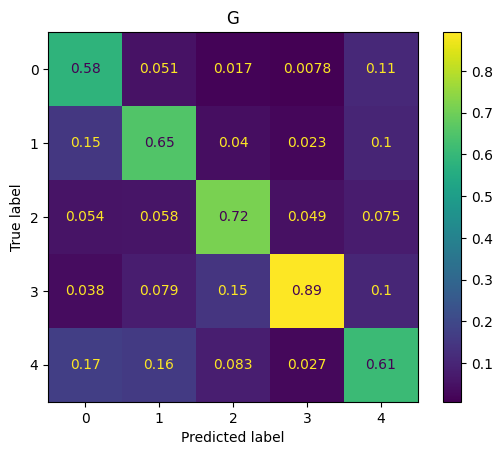

In [12]:
if _run_task(tasks, "G"):
    print("\n==== Task G: Remove Data Augmentation ====")
    model = create_model(tf.keras.applications.EfficientNetV2B0, "G", params, batch_norm=True)
    run_task(f"G", model, ds_train_cached, ds_valid, ds_test, params, collector, class_weights)
    del model


==== Task H: Remove Class Weights ====
Running Task: H with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 88s 709ms/step - accuracy: 0.4752 - loss: 1.7033 - val_accuracy: 0.6836 - val_loss: 0.9273
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.6607 - loss: 0.9859 - val_accuracy: 0.7404 - val_loss: 0.8212
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.6938 - loss: 0.8623 - val_accuracy: 0.7533 - val_loss: 0.7567
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7111 - loss: 0.8050 - val_accuracy: 0.7624 - val_loss: 0.7208
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7308 - loss: 0.7337 - val_accuracy: 0.7647 - val_loss: 0.6859
Epoch 6/75
67/67 ━━━━━━━━━━

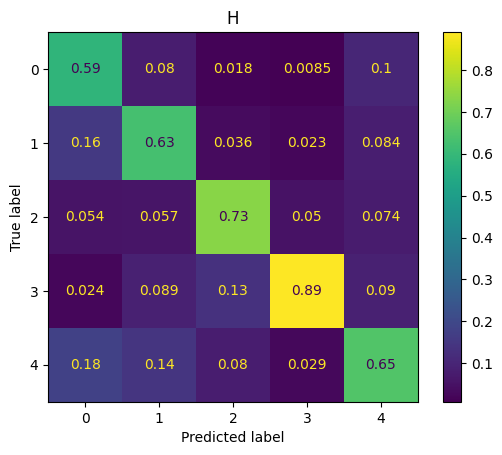

In [13]:
if _run_task(tasks, "H"):
    print("\n==== Task H: Remove Class Weights ====")
    model = create_model(tf.keras.applications.EfficientNetV2B0, "H", params, batch_norm=True)
    run_task(f"H", model, ds_train_cached, ds_valid, ds_test, params, collector)
    del model


==== Task I: Remove Batch Norm ====
Running Task: I with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 786ms/step - accuracy: 0.5221 - loss: 1.2900 - val_accuracy: 0.6612 - val_loss: 0.8759
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6626 - loss: 0.9221 - val_accuracy: 0.7140 - val_loss: 0.7543
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6887 - loss: 0.8343 - val_accuracy: 0.7374 - val_loss: 0.7089
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7101 - loss: 0.7917 - val_accuracy: 0.7453 - val_loss: 0.6845
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7220 - loss: 0.7509 - val_accuracy: 0.7514 - val_loss: 0.6682
Epoch 6/75
67/67 ━━━━━━━━━━━━━

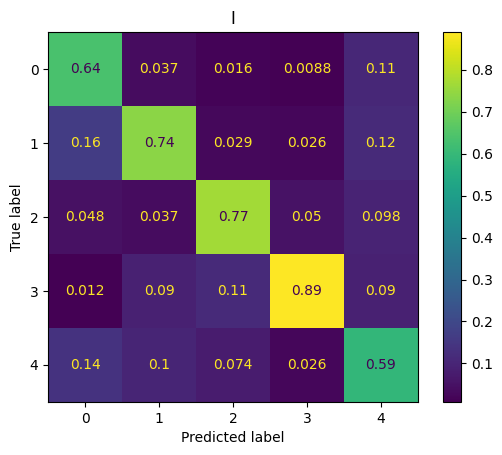

In [14]:
if _run_task(tasks, "I"):
    print("\n==== Task I: Remove Batch Norm ====")
    model = create_model(tf.keras.applications.EfficientNetV2B0, "I", params)
    run_task(f"I", model, ds_train_cached, ds_valid, ds_test, params, collector)
    del model

In [7]:
# now regress to Adam
params.opt = Adam
print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)



==== Task J: Regress to the Adam Optimiser ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Running Task: J with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
 1/67 ━━━━━━━━━━━━━━━━━━━━ 1:09:33 63s/step - accuracy: 0.1198 - loss: 1.8497

I0000 00:00:1712748482.797558     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5191 - loss: 1.3077 - val_accuracy: 0.6645 - val_loss: 0.8731
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6566 - loss: 0.9344 - val_accuracy: 0.7145 - val_loss: 0.7586
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.6950 - loss: 0.8245 - val_accuracy: 0.7357 - val_loss: 0.7118
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7017 - loss: 0.7925 - val_accuracy: 0.7460 - val_loss: 0.6876
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7197 - loss: 0.7573 - val_accuracy: 0.7542 - val_loss: 0.6682
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7234 - loss: 0.7432 - val_accuracy: 0.7565 - val_loss: 0.6542
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7287 - loss: 0.7198 - val_accuracy: 0.7612 - val_loss: 0.6421
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.7465 - loss: 0.7040 - val_accuracy: 0.7633 

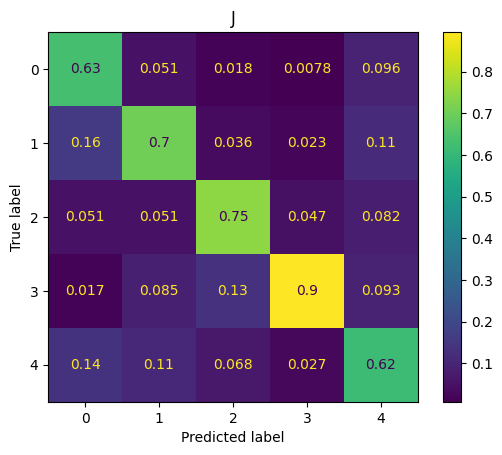

In [8]:
if _run_task(tasks, "J"):
    print("\n==== Task J: Regress to the Adam Optimiser ====")
    model = create_model(tf.keras.applications.EfficientNetV2B0, "J", params)
    run_task(f"J", model, ds_train_cached, ds_valid, ds_test, params, collector)
    del model


==== Task K: Remove a FC Layer ====
Running Task: K with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 90s 743ms/step - accuracy: 0.5220 - loss: 1.2678 - val_accuracy: 0.6925 - val_loss: 0.8290
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.6834 - loss: 0.8623 - val_accuracy: 0.7290 - val_loss: 0.7328
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.7081 - loss: 0.7920 - val_accuracy: 0.7444 - val_loss: 0.6959
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.7224 - loss: 0.7499 - val_accuracy: 0.7514 - val_loss: 0.6727
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.7395 - loss: 0.7156 - val_accuracy: 0.7544 - val_loss: 0.6565
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━

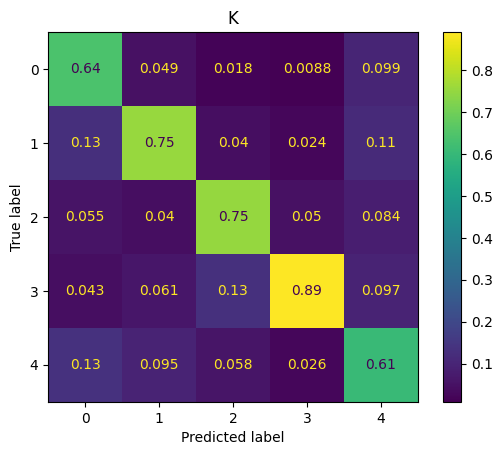

In [9]:
if _run_task(tasks, "K"):
    print("\n==== Task K: Remove a FC Layer ====")
    model = create_model(tf.keras.applications.EfficientNetV2B0, "K", params, 1)
    run_task(f"K", model, ds_train_cached, ds_valid, ds_test, params, collector)
    del model

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

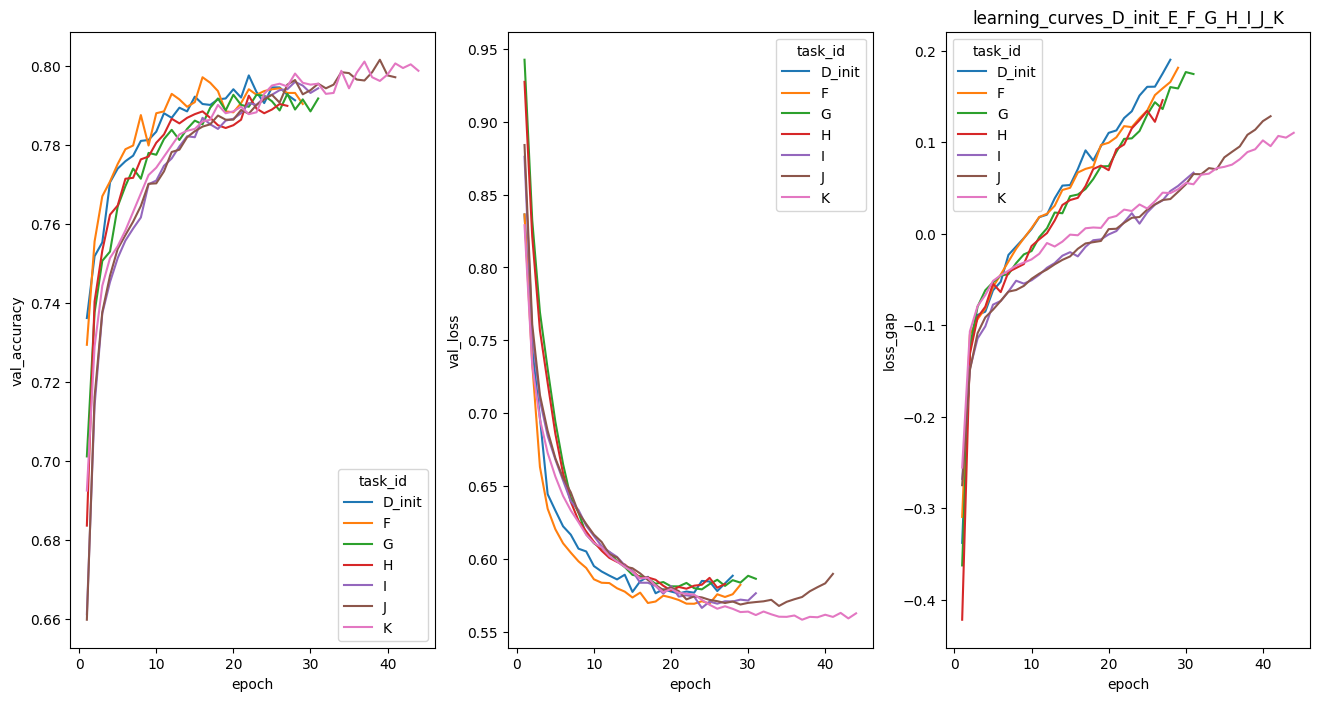

In [10]:
plot_task_comp(collector, ["D_init", "E", "F", "G", "H", "I", "J", "K"])


==== Task L: Create a Custom Convnet ====
Running Task: L with params Params(image_size=255, batch_size=192, epochs=5, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adam.Adam'>)
Using: <class 'keras.src.optimizers.adam.Adam'>
Using EarlyStopping
Epoch 1/5


2024-04-10 11:47:02.147691: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,3,255,255]{3,2,1,0}, f32[192,32,255,255]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-10 11:47:02.567959: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.420297061s
Trying algorithm eng0{} for conv (f32[32,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,3,255,255]{3,2,1,0}, f32[192,32,255,255]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-10 11:47:05.428839: E external/

66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.5728 - loss: 1.5619

2024-04-10 11:49:06.326850: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[165,3,255,255]{3,2,1,0}, f32[165,32,255,255]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-10 11:49:06.526717: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.200059007s
Trying algorithm eng0{} for conv (f32[32,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[165,3,255,255]{3,2,1,0}, f32[165,32,255,255]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-10 11:49:09.131202: E external/

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5732 - loss: 1.5606   

W0000 00:00:1712749789.254006     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712749802.752849     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.5737 - loss: 1.5594 - val_accuracy: 0.6164 - val_loss: 1.1916
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 44s 621ms/step - accuracy: 0.6177 - loss: 1.1938 - val_accuracy: 0.6164 - val_loss: 1.2114
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 44s 620ms/step - accuracy: 0.6179 - loss: 1.1850 - val_accuracy: 0.6164 - val_loss: 1.2074
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 619ms/step - accuracy: 0.6187 - loss: 1.1843 - val_accuracy: 0.6164 - val_loss: 1.1986
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 44s 617ms/step - accuracy: 0.6183 - loss: 1.1836 - val_accuracy: 0.6164 - val_loss: 1.1943
Restoring model weights from the end of the best epoch: 1.
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - accuracy: 0.6184 - loss: 1.1876


W0000 00:00:1712750045.560843     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6103 - loss: 1.2005
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.4172 - loss: 1.5547
Train Result: [1.1978012323379517, 0.612370491027832]; Valid Result: [1.1915532350540161, 0.6163551211357117]; Test Result: [1.213282823562622, 0.6212616562843323]
 2/23 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step 

W0000 00:00:1712750070.220427     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step


W0000 00:00:1712750073.625438     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts


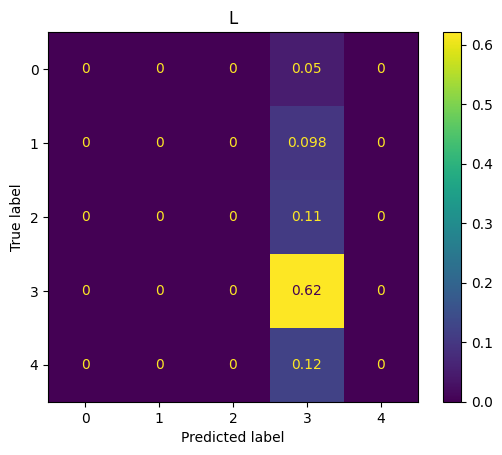

In [11]:
if _run_task(tasks, "L"):
    print("\n==== Task L: Create a Custom Convnet ====")
    model = create_simple_model(params)
    simple_params = dataclasses.replace(params)
    simple_params.epochs = 5
    run_task(f"L", model,
             convert_dataset_to_float(ds_train),
             convert_dataset_to_float(ds_valid),
             convert_dataset_to_float(ds_test), simple_params, collector)

In [8]:
# return to AdamW for best-of-breed # 2
params.opt = AdamW

# create common input for later ensembles
inputs = tf.keras.Input(shape=(params.image_size, params.image_size, 3))

print(params)

Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)



==== Task M: New Best of Breed ====
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Running Task: M_init with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
  1/134 ━━━━━━━━━━━━━━━━━━━━ 2:16:20 62s/step - accuracy: 0.2083 - loss: 1.6659

I0000 00:00:1712656749.862323     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 68/134 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.5479 - loss: 1.2461 

W0000 00:00:1712656827.728194     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5888 - loss: 1.1385 - val_accuracy: 0.7203 - val_loss: 0.7403
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 583ms/step - accuracy: 0.7089 - loss: 0.7926 - val_accuracy: 0.7500 - val_loss: 0.6780
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 566ms/step - accuracy: 0.7305 - loss: 0.7335 - val_accuracy: 0.7629 - val_loss: 0.6484
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 569ms/step - accuracy: 0.7467 - loss: 0.6974 - val_accuracy: 0.7596 - val_loss: 0.6400
Epoch 5/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 573ms/step - accuracy: 0.7566 - loss: 0.6711 - val_accuracy: 0.7706 - val_loss: 0.6199
Epoch 6/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 566ms/step - accuracy: 0.7637 - loss: 0.6524 - val_accuracy: 0.7773 - val_loss: 0.6062
Epoch 7/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - accuracy: 0.7671 - loss: 0.6423 - val_accuracy: 0.7813 - val_loss: 0.5983
Epoch 8/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 560ms/step - accuracy: 0.7738 - loss: 0.6237 - val_a

W0000 00:00:1712659942.097092     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 561ms/step - accuracy: 0.8713 - loss: 0.3803
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7973 - loss: 0.5518
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.7283 - loss: 0.7546
Train Result: [0.3778686821460724, 0.871660053730011]; Valid Result: [0.5520170331001282, 0.800000011920929]; Test Result: [0.5390863418579102, 0.8212617039680481]
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step
Saving confusion matrix to artefacts
Running Task: M_tuned with params Params(image_size=255, batch_size=192, epochs=1, epsilon=1e-05, early_stopping=True, early_stopping_patience=1, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping


2024-04-09 10:54:49.660132: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-09 10:54:49.779738: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.119814713s
Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[192,32,64,64]{3,2,1,0}, f32[192,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-09 10:54:51.183866: E external/

 66/134 ━━━━━━━━━━━━━━━━━━━━ 40s 603ms/step - accuracy: 0.7175 - loss: 0.8115

W0000 00:00:1712660262.818425     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.7600 - loss: 0.6916 - val_accuracy: 0.8287 - val_loss: 0.5180
Restoring model weights from the end of the best epoch: 1.
 68/134 ━━━━━━━━━━━━━━━━━━━━ 40s 612ms/step - accuracy: 0.8607 - loss: 0.3846

W0000 00:00:1712660356.992991     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 573ms/step - accuracy: 0.8633 - loss: 0.3805
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8299 - loss: 0.5127
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7424 - loss: 0.6933
Train Result: [0.36191245913505554, 0.8708031177520752]; Valid Result: [0.5179668068885803, 0.8287383317947388]; Test Result: [0.49613305926322937, 0.8341121673583984]
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 341ms/step
Saving confusion matrix to artefacts


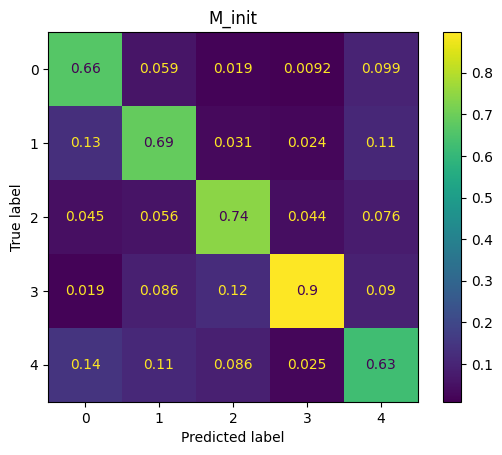

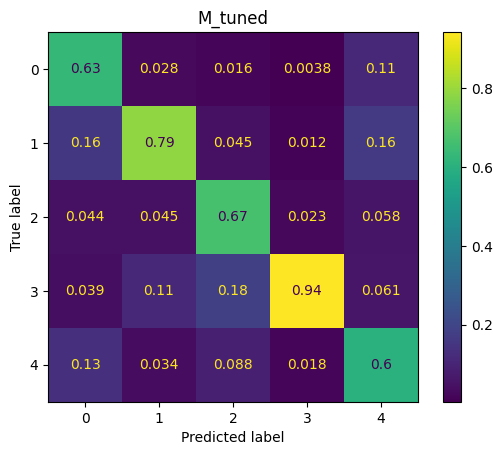

In [8]:
print("\n==== Task M: New Best of Breed ====")
model_m = create_model(tf.keras.applications.EfficientNetV2B0, "M", params, fc_layers=1, inputs=inputs)
run_task(f"M_init", model_m, ds_train_aug, ds_valid, ds_test, params, collector, class_weights)
# fine-tune  
model_m.base_model.trainable = True
run_task(f"M_tuned", model_m, ds_train_aug, ds_valid, ds_test, ft_params, collector, class_weights)
model_m.base_model.trainable = False
model_m.model.trainable = False


==== Task N: Ensemble ====
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Running Task: N_train with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5692 - loss: 1.2181

W0000 00:00:1712660614.217618     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712660614.218149     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712660614.218696     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5701 - loss: 1.2155 - val_accuracy: 0.7157 - val_loss: 0.7599
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6912 - loss: 0.8128 - val_accuracy: 0.7540 - val_loss: 0.6716
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7404 - loss: 0.7089 - val_accuracy: 0.7741 - val_loss: 0.6213
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7587 - loss: 0.6626 - val_accuracy: 0.7918 - val_loss: 0.5861
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7746 - loss: 0.6166 - val_accuracy: 0.7977 - val_loss: 0.5591
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7842 - loss: 0.5900 - val_accuracy: 0.8105 - val_loss: 0.5386
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7973 - loss: 0.5656 - val_accuracy: 0.8154 - val_loss: 0.5267
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7966 - loss: 0.5558 - val_accuracy: 0.8178 - val_loss: 0.

W0000 00:00:1712664394.183025     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712664394.183340     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712664394.183782     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts


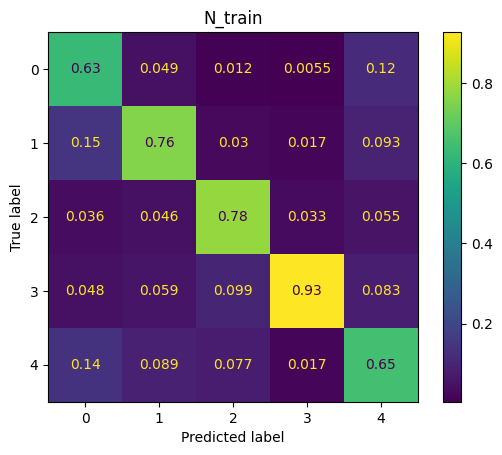

In [10]:
#if _run_task(tasks, "N"):
print("\n==== Task N: Ensemble ====")
convnext_base = create_model(tf.keras.applications.ConvNeXtBase, "N", params, fc_layers=1, inputs=inputs)
run_task(f"N_train", convnext_base, ds_train_cached, ds_valid, ds_test, params, collector, class_weights)

In [11]:
convnext_base.base_model.trainable = False
convnext_base.model.trainable = False

Running Task: N with params Params(image_size=255, batch_size=192, epochs=75, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False, opt=<class 'keras.src.optimizers.adamw.AdamW'>)
Using: <class 'keras.src.optimizers.adamw.AdamW'>
Using EarlyStopping
Epoch 1/75


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


66/67 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9041 - loss: 0.3098

W0000 00:00:1712664559.501654     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9042 - loss: 0.3096

W0000 00:00:1712664611.528934     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712664611.529277     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712664611.529757     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.9043 - loss: 0.3094 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9009 - loss: 0.3106 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9042 - loss: 0.3108 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9017 - loss: 0.3104 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9082 - loss: 0.3077 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9032 - loss: 0.3115 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9031 - loss: 0.3097 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9022 - loss: 0.3094 - val_accuracy: 0.8603 - val_loss: 0.

W0000 00:00:1712665533.122020     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9078 - loss: 0.2842
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8601 - loss: 0.4096
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7778 - loss: 0.5847
Train Result: [0.27004387974739075, 0.9195294976234436]; Valid Result: [0.41829797625541687, 0.8602803945541382]; Test Result: [0.4132545292377472, 0.8656542301177979]
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step


W0000 00:00:1712665645.924728     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712665645.925182     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712665645.925777     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts


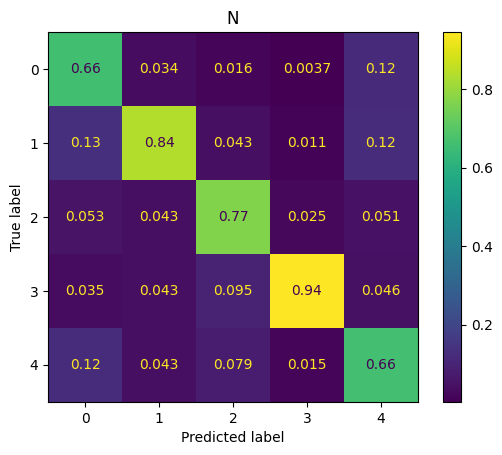

In [12]:
params.epochs = 1
params.early_stopping_patience = 1
model_n = create_model_ensemble_avg(params, inputs, [model_m, convnext_base])
model_n.trainable = False
run_task(f"N", model_n, ds_train_cached, ds_valid, ds_test, params, collector, class_weights)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert

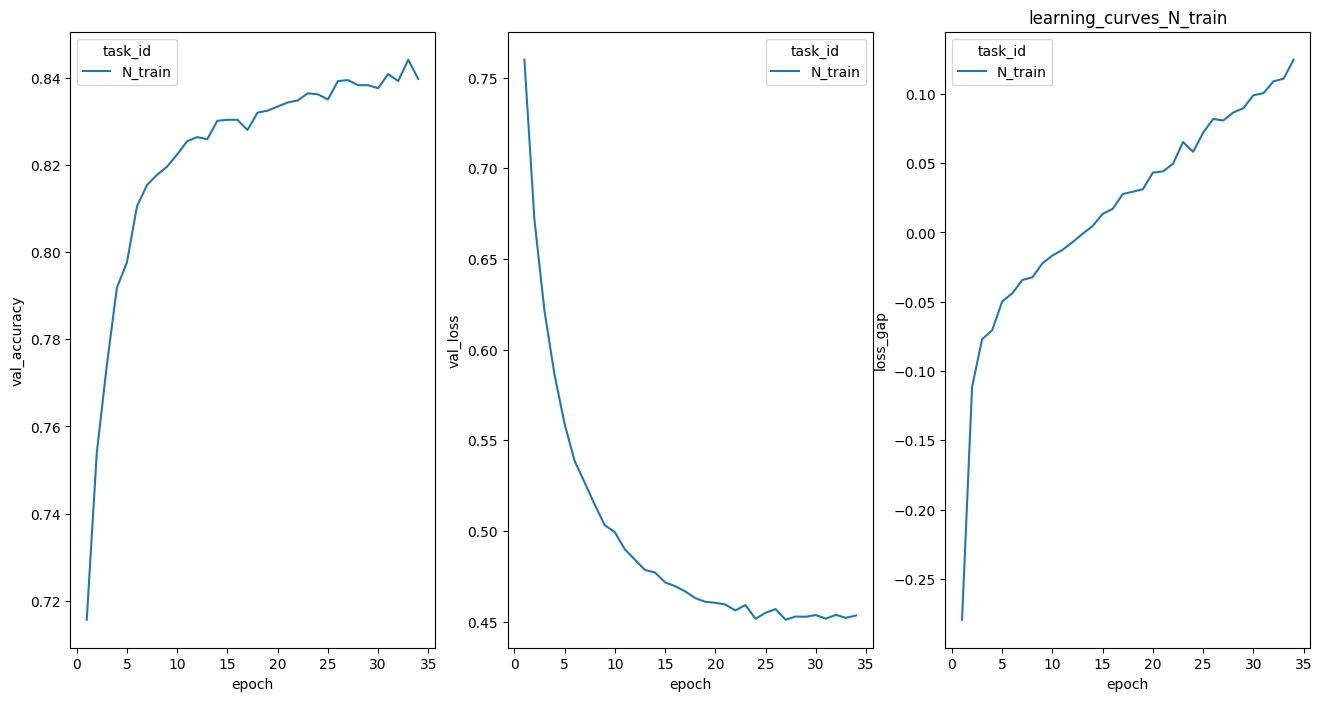

In [14]:
plot_task_comp_by_prefix(collector, "N")

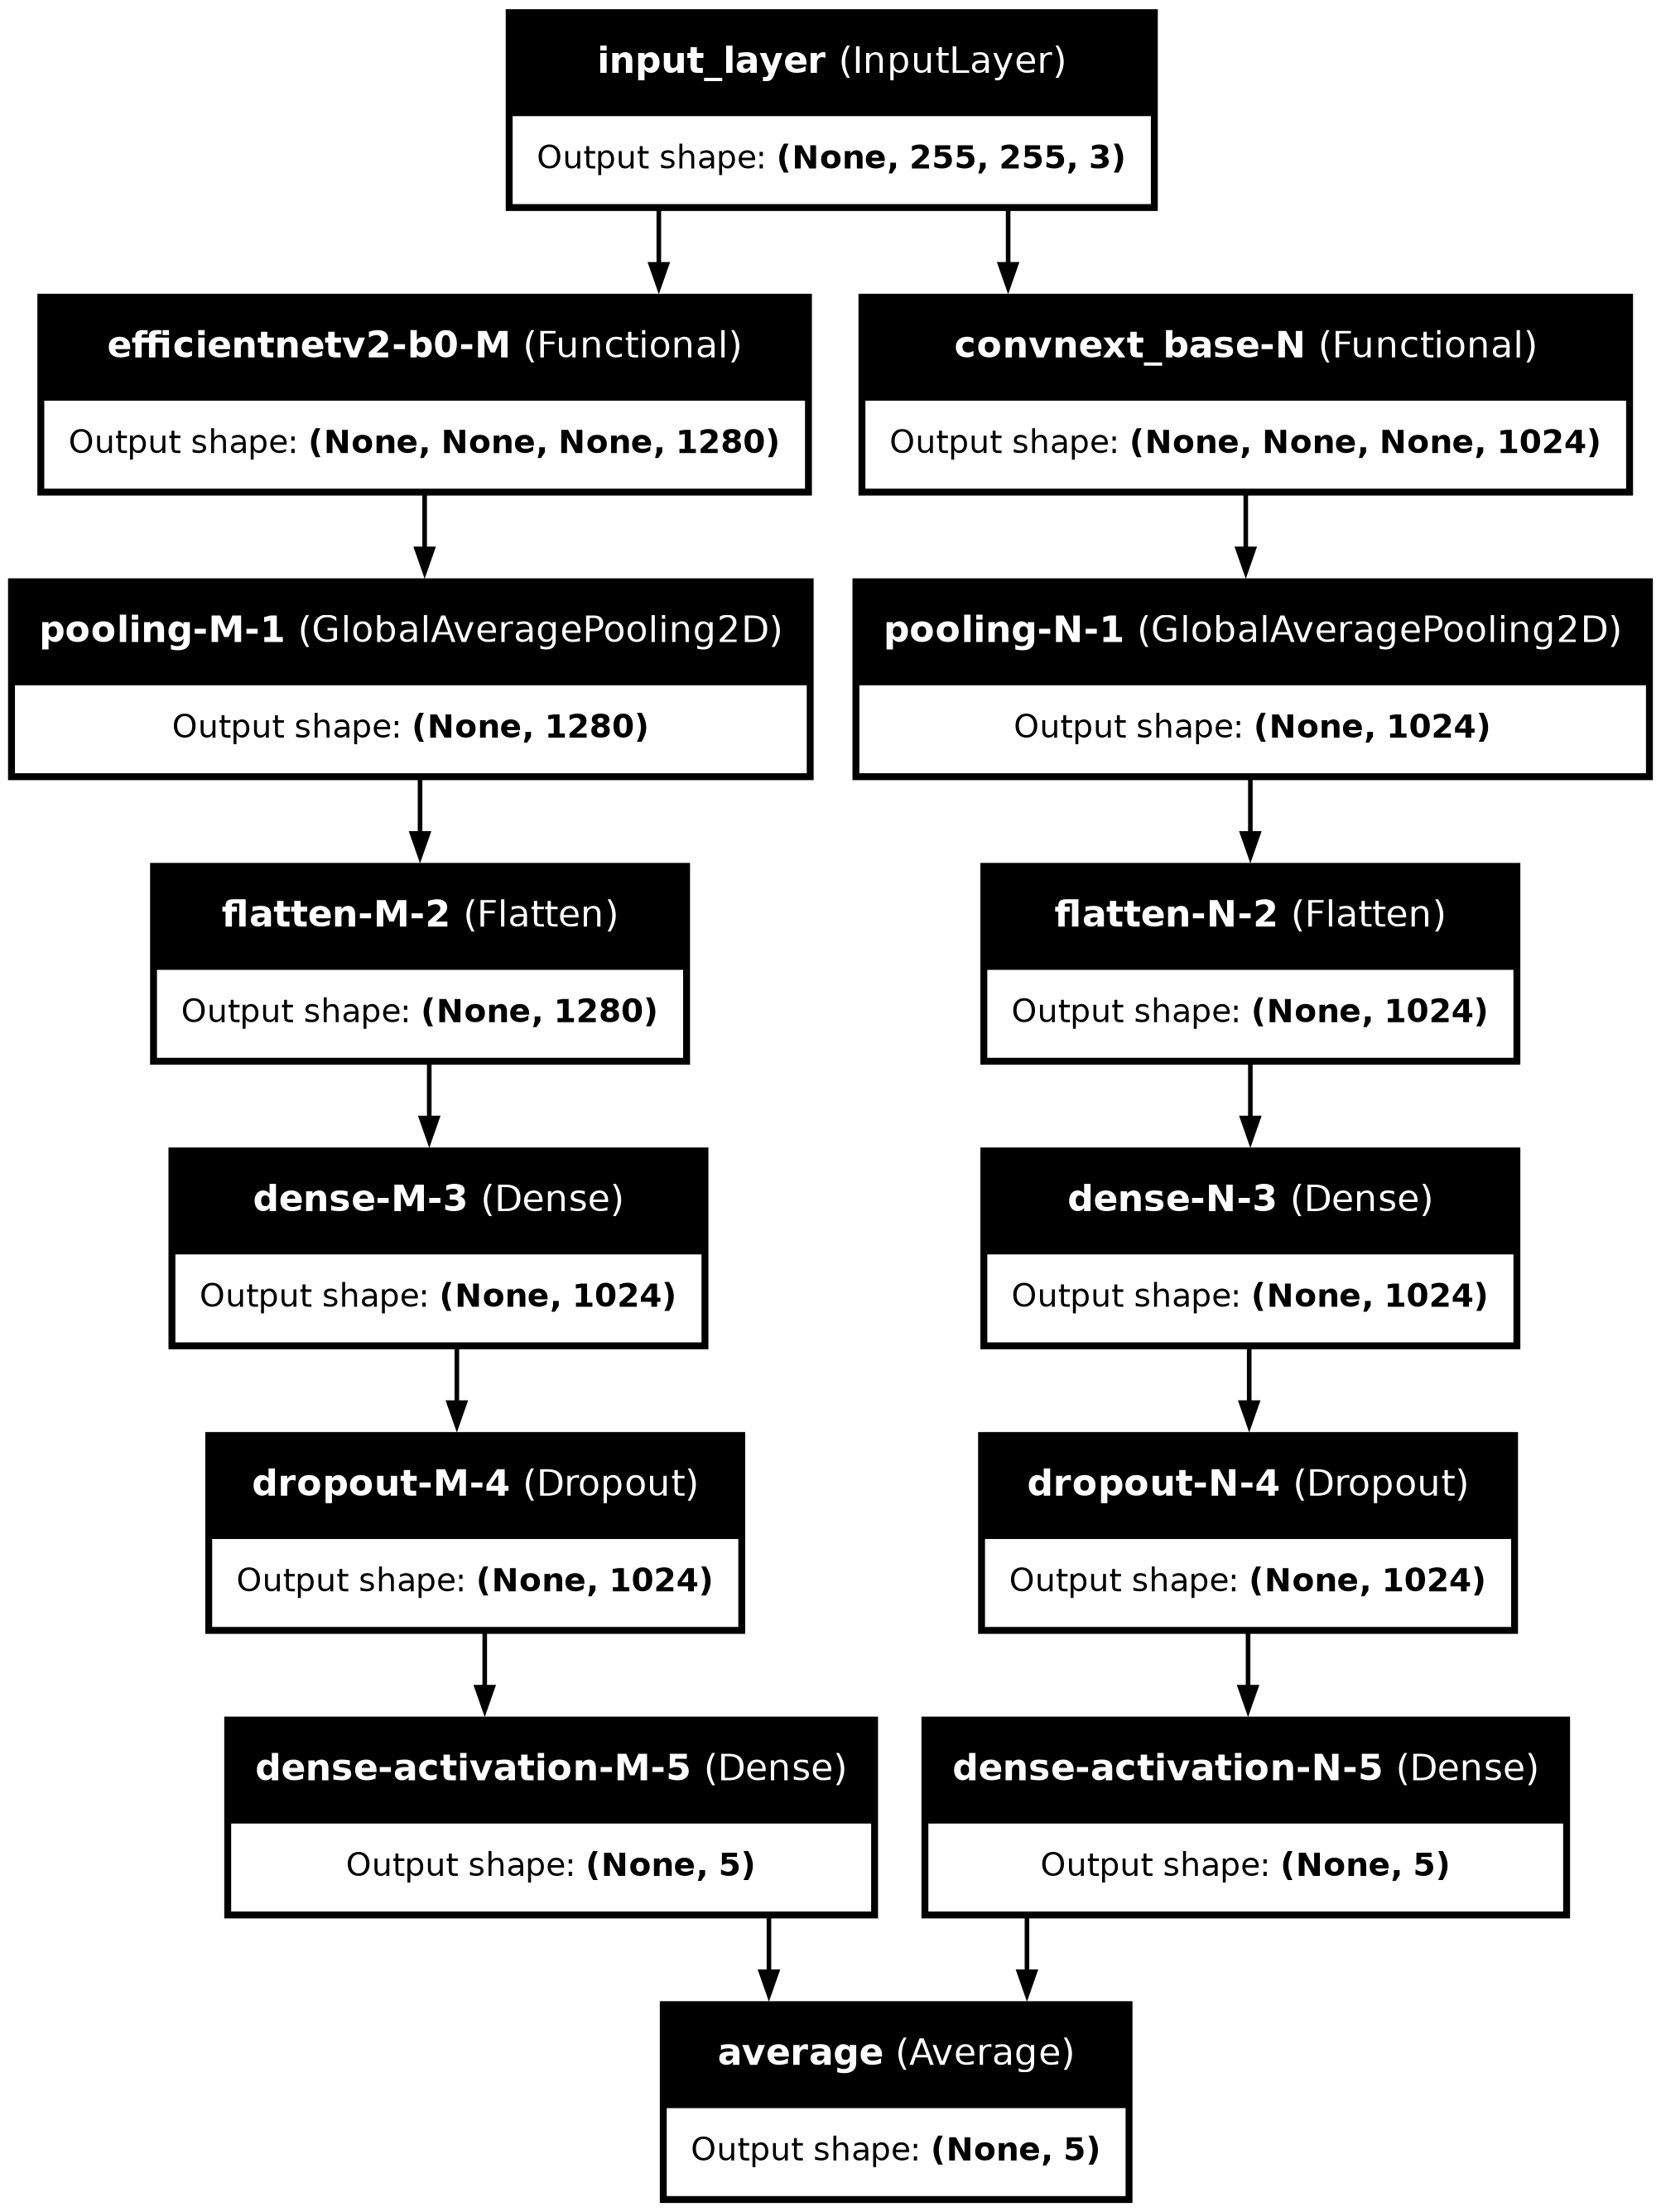

In [18]:
from keras.utils import plot_model
plot_model(model_n.model, to_file='model_n_ensemble.png', show_shapes=True, show_layer_names=True)